# Imports

Import the required libraries.

In [1]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf

2023-04-17 03:22:14.456575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the dataset

Enter the Unix glob file pattern of the data files.

Here we load the training data. All the data are stored in TensorFlow Record files.
Replace 'train' with 'eval' or 'test' to load the evaluation or testing data, respectively.

In [2]:
file_pattern = '../archive/next_day_wildfire_spread_train*'

Run the following three cells to define the required library functions for loading the data.

The first cell defines the name of the variables in the input files and the corrresponding data statistics. The statistics can be used for preprocessing the data. 

In [3]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    
    # Drought Index (Palmer Drought Severity Index)
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    
    #Vegetation index (times 10,000 maybe, since it's supposed to be b/w -1 and 1?)
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
   
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
   
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    
    # Min/max temperature in Kelvin.
    
    #Min temp
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    
    #Max temp
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

The following cell defines cropping functions for extracting regions of the desired size from the input data.

In [4]:
"""Library of common functions used in deep learning neural networks.
"""
#YOU PROBABLY WILL NOT USE THESE.

def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

The following cell provides code for parsing the contents of the TensorFlow Record files. In addition to loading the data, it also offers functions for various preprocessing operations, such as clipping, rescaling, or normalizing the data.  

In [5]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [6]:
input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
feature_names = input_features + output_features
features_dict = _get_features_dict(64, feature_names)
features_dict

{'pdsi': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'pr': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'th': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'tmmx': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'erc': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'population': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'PrevFireMask': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'sph': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'NDVI': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'FireMask': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'tmmn': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'elevation': FixedLenFeature(shape=[64, 64], dtype=tf.float32, default_value=None),
 'vs': FixedLenFeature(

In [7]:
import numpy as np

train_dataset = tf.data.Dataset.list_files('../archive/next_day_wildfire_spread_train*')

train_dataset = train_dataset.interleave(
    lambda x: tf.data.TFRecordDataset(x),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# Potential bug? - Random crop must be enabled otherwise the images will always be 64 x 64
train_dataset = train_dataset.map(
    lambda x: _parse_fn(x, 64, 32, 12, False, False, True, False),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

test_dataset = tf.data.Dataset.list_files('../archive/next_day_wildfire_spread_test*')

test_dataset = test_dataset.interleave(
    lambda x: tf.data.TFRecordDataset(x),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

test_dataset = test_dataset.map(
    lambda x: _parse_fn(x, 64, 32, 12, False, False, True, False),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

validation_dataset = tf.data.Dataset.list_files('../archive/next_day_wildfire_spread_eval*')

validation_dataset = validation_dataset.interleave(
    lambda x: tf.data.TFRecordDataset(x),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

validation_dataset = validation_dataset.map(
    lambda x: _parse_fn(x, 64, 32, 12, False, False, True, False),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-17 03:22:15.840739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 03:22:15.842723: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# Convert the tensorflow data into numpy arrays so that the pytorch datasets can be easily initialized with them.

x_train = np.moveaxis(np.array([np.concatenate((x[0].numpy(), x[1].numpy()), axis=2) for x in train_dataset]), 3, 1)
x_test = np.moveaxis(np.array([np.concatenate((x[0].numpy(), x[1].numpy()), axis=2) for x in test_dataset]), 3, 1)
x_validation = np.moveaxis(np.array([np.concatenate((x[0].numpy(), x[1].numpy()), axis=2) for x in validation_dataset]), 3, 1)

In [9]:
def remove_bad_samples(dataset):
    # bad samples are any target fire masks with missing data
    fire_masks_array = np.array(dataset[:, 12, :, :])
    good_indices = []

    for img_num in range(len(fire_masks_array)):
        if np.all(np.invert(fire_masks_array[img_num, :, :] == -1)):
            good_indices.append(img_num)

    return dataset[good_indices]

In [10]:
x_train = remove_bad_samples(x_train)
# Bad samples are removed from the test and evaluation datasets
# If missing data is left in, then it will need to be handled appropriately in the testing
x_test = remove_bad_samples(x_test)
x_validation = remove_bad_samples(x_validation)

In [18]:
print(np.amax(x_train[:, 1, :, :]))

37735.63


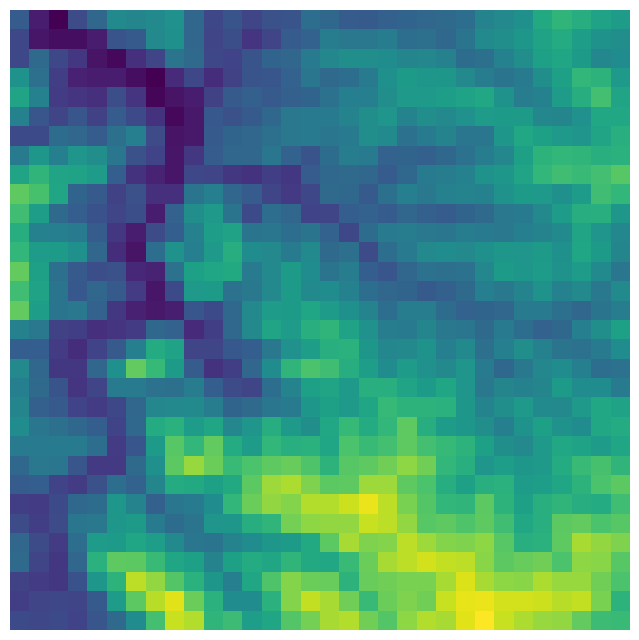

In [12]:
fig = plt.figure(figsize=(15,6.5))

#plt.subplot(1, 1, 1)

plt.imshow(x_train[0, 0, :, :], cmap='viridis') # elevation

plt.axis('off')

plt.tight_layout()

In [13]:
np.unique(x_train[:, 11, :, :].flatten(), return_counts=True)

(array([-1.,  0.,  1.], dtype=float32), array([   77182, 12367359,   232579]))

In [14]:
# This shows one of the major downsides to the dataset, overwhelming majority of the fire mask pixels are the "no fire" class

x1 = np.unique(x_train[:, 11, :, :].flatten(), return_counts=True)
x2 = np.unique(x_test[:, 11, :, :].flatten(), return_counts=True)
x3 = np.unique(x_validation[:, 11, :, :].flatten(), return_counts=True)

prev_fire_mask_counts = np.vstack((x1[1], x2[1], x3[1]))
prev_fire_mask_total_missing = prev_fire_mask_counts[:, 0].sum()
prev_fire_mask_total_no_fire = prev_fire_mask_counts[:, 1].sum()
prev_fire_mask_total_fire = prev_fire_mask_counts[:, 2].sum()
total_prev_fire_mask_pixels = prev_fire_mask_total_missing + prev_fire_mask_total_no_fire + prev_fire_mask_total_fire

print("Previous Fire Mask:")
print(f"\tmissing data = {prev_fire_mask_total_missing} - {100 * prev_fire_mask_total_missing / total_prev_fire_mask_pixels}%")
print(f"\tno fire = {prev_fire_mask_total_no_fire} - {100 * prev_fire_mask_total_no_fire / total_prev_fire_mask_pixels}%")
print(f"\tfire = {prev_fire_mask_total_fire} - {100 * prev_fire_mask_total_fire / total_prev_fire_mask_pixels}%")

x4 = np.unique(x_train[:, 12, :, :].flatten(), return_counts=True)
x5 = np.unique(x_test[:, 12, :, :].flatten(), return_counts=True)
x6 = np.unique(x_validation[:, 12, :, :].flatten(), return_counts=True)

fire_mask_counts = np.vstack((x4[1], x5[1], x6[1]))
fire_mask_total_no_fire = fire_mask_counts[:, 0].sum()
fire_mask_total_fire = fire_mask_counts[:, 1].sum()
total_fire_mask_pixels = fire_mask_total_no_fire + fire_mask_total_fire

print("Fire Mask:")
print(f"\tno fire = {fire_mask_total_no_fire} - {100 * fire_mask_total_no_fire / total_fire_mask_pixels}%")
print(f"\tfire = {fire_mask_total_fire} - {100 * fire_mask_total_fire / total_fire_mask_pixels}%")

Previous Fire Mask:
	missing data = 102946 - 0.6564790591942014%
	no fire = 15287646 - 97.48819248318532%
	fire = 290944 - 1.855328457620478%
Fire Mask:
	no fire = 15245032 - 97.21644614405119%
	fire = 436504 - 2.783553855948805%


In [15]:
print(set(x_train[:,11:13,:,:].flatten()))
print(set(x_test[:,11:13,:,:].flatten()))
print(set(x_validation[:,11:13,:,:].flatten()))

{0.0, 1.0, -1.0}
{0.0, 1.0, -1.0}
{0.0, 1.0, -1.0}


## Oversampling stuff

In [16]:
np.unique(x_train[0, 12], return_counts=True)

(array([0., 1.], dtype=float32), array([1020,    4]))

In [22]:
train_target_fire_percentage_count = 0 # counts how many fire masks have fire pixels greater than the threshold
train_target_indices = [] # This will be passed into the OversampleWildfireDataset constructor
train_previous_fire_percentage_count = 0

print(len(x_train))
for i in range(len(x_train)):
    unique_target, counts_target = np.unique(x_train[i, 12], return_counts=True)
    target_counts_map = {int(unique_target[i]): int(counts_target[i]) for i in range(len(unique_target))}

    for key, value in target_counts_map.items():
        if key == 1 and (value/1024) >= 0.01: # adjust the fraction to see which masks have a lot of fire
            train_target_fire_percentage_count += 1
            train_target_indices.append(i)
        
print(train_target_fire_percentage_count)
print(train_target_indices)

12380
6911
[2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 35, 36, 37, 39, 40, 43, 45, 46, 48, 50, 52, 54, 57, 60, 61, 62, 64, 65, 68, 70, 71, 72, 73, 74, 77, 79, 81, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 99, 100, 101, 102, 107, 109, 112, 113, 114, 115, 117, 118, 119, 121, 122, 124, 125, 126, 127, 129, 130, 132, 133, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 147, 148, 150, 151, 152, 154, 155, 157, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 173, 175, 177, 178, 179, 182, 184, 186, 187, 190, 192, 193, 195, 196, 197, 199, 200, 201, 202, 203, 207, 208, 209, 211, 212, 213, 214, 216, 218, 220, 222, 224, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 249, 250, 251, 252, 253, 255, 256, 258, 260, 262, 264, 269, 270, 271, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 285, 286, 287, 288, 289, 291, 292, 293, 294, 295, 297, 298, 300, 303, 305, 308, 310, 311, 313, 314, 315, 316, 319, 320, 321, 322, 323, 326, 

# The Datasets for PyTorch

In [17]:
import random
import torch
from torch.utils.data import Dataset, IterableDataset, DataLoader


class OversampledWildfireDataset(torch.utils.data.Dataset):
    def __init__(self, wildfire_data, oversample_indices, transform=None):
        self.wildfire_data = wildfire_data
        self.oversample_indices = oversample_indices

    def __len__(self):
        return len(self.wildfire_data) * 2

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        idx = idx if idx < len(self.wildfire_data)//2 else self._get_random_oversample_index()

        sample = {'inputs': torch.from_numpy(self.wildfire_data[idx, 0:12, :, :]), 
                  'labels': torch.from_numpy(np.expand_dims(self.wildfire_data[idx, 12, :, :], axis=0))
                 }
        
        return sample
    
    def _get_random_oversample_index(self):
        return random.choice(self.oversample_indices)

class WildfireDataset(torch.utils.data.Dataset):
    def __init__(self, wildfire_data, transform=None):
        self.wildfire_data = wildfire_data

    def __len__(self):
        return len(self.wildfire_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #elevation = self.wildfire_data[idx, 0, :, :]
        #wind_direction = self.wildfire_data[idx, 1, :, :]
        #wind_velocity = self.wildfire_data[idx, 2, :, :]
        #min_temp = self.wildfire_data[idx, 3, :, :]
        #max_temp = self.wildfire_data[idx, 4, :, :]
        #humidity = self.wildfire_data[idx, 5, :, :]
        #precipitation = self.wildfire_data[idx, 6, :, :]
        #drought = self.wildfire_data[idx, 7, :, :]
        #vegetation = self.wildfire_data[idx, 8, :, :]
        #pop_density = self.wildfire_data[idx, 9, :, :]
        #erc = self.wildfire_data[idx, 10, :, :]
        #prev_fire_mask = self.wildfire_data[idx, 11, :, :]
        #fire_mask = self.wildfire_data[idx, 12, :, :] # Target
        sample = {'inputs': torch.from_numpy(self.wildfire_data[idx, 0:12, :, :]), 
                  'labels': torch.from_numpy(np.expand_dims(self.wildfire_data[idx, 12, :, :], axis=0))
                 }

        return sample

In [18]:
from torch.autograd import Variable

train_dataset = OversampledWildfireDataset(x_train, train_target_indices)
test_dataset = WildfireDataset(x_test)
validation_dataset = WildfireDataset(x_validation)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=100, shuffle=True, num_workers=0)

# The Neural Networks

In [19]:
# Neural networks that can be used on the dataset

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.linear(x))
        x = x.reshape(-1, 1, 32, 32)
        return x

class BinaryClassifierCNN(torch.nn.Module):
    # Make sure the training data is scrubbed of any target fire masks that have missing data
    def __init__(self, image_size):
        flattened_conv2_output_dimensions = (image_size//4)**2
        super(BinaryClassifierCNN, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(12, 16, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(32 * flattened_conv2_output_dimensions, 1024), # 1024 pixels, output represents probability of fire.
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        x = x.reshape(-1, 1, 32, 32)
        return x
    

# Tutorial for the autoencoder: https://www.youtube.com/watch?v=345wRyqKkQ0
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    
    def forward(self, x):
        return x.view(self.shape)
    
class Trim(torch.nn.Module):
    def __init__(self, *args):
        super(Trim, self).__init__()
    
    def forward(self, x):
        return x[:, :, :32, :32]

class ConvolutionalAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(12, 16, 3, 1, 0), # 32 x 32 -> 30 x 30
            torch.nn.LeakyReLU(0.01),
            torch.nn.Dropout(0.1),
            torch.nn.Conv2d(16, 32, 3, 2, 0), # 30 x 30 -> 14 x 14
            torch.nn.LeakyReLU(0.01),
            torch.nn.Dropout(0.1),
            torch.nn.Conv2d(32, 32, 3, 2, 0), # 14 x 14 -> 6 x 6
            torch.nn.Flatten(),
            torch.nn.Linear(1152, 2) # 1152 = 32 * 6  * 6
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 1152),
            Reshape(-1, 32, 6, 6),
            torch.nn.ConvTranspose2d(32, 32, 3, 1, 0), # 6 x 6 -> 8 x 8
            torch.nn.LeakyReLU(0.01),
            torch.nn.ConvTranspose2d(32, 16, 3, 2, 1), # 8 x 8 -> 15 x 15
            torch.nn.LeakyReLU(0.01),
            torch.nn.ConvTranspose2d(16, 16, 3, 2, 0), # 15 x 15 -> 31 x 31
            torch.nn.LeakyReLU(0.01),
            torch.nn.ConvTranspose2d(16, 1, 3, 1, 0), # 31 x 31 -> 33 x 33
            Trim(),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
test_model = ConvolutionalAutoencoder()
test_criterion = torch.nn.BCELoss()
test_optimizer = torch.optim.Adam(test_model.parameters(), lr=0.001)

loss_history = []
for epoch in range(1):
    total_steps = 0
    for i, batch in enumerate(train_loader):
        batch_inputs = batch['inputs']
        # batch_inputs = batch_inputs.reshape((batch_inputs.size(0), -1)) # only needed for Linear input layer
        batch_labels = batch['labels']
        
        test_optimizer.zero_grad()
        
        out = test_model(batch_inputs)
        
        target = torch.flatten(batch_labels)
        out = torch.flatten(out)
        
        loss = test_criterion(out, target) 
    
        loss.backward()
    
        test_optimizer.step()
        
        total_steps += 1
        loss_history.append(loss.item())
        
    print ('Epoch [{}], Steps {}, Loss: {:.4f}'.format(epoch + 1, total_steps, loss.item()))

Epoch [1], Steps 248, Loss: 0.4172


# Training

In [21]:
def train_model(train_loader, num_epochs, model, criterion, optimizer):
    loss_history = []
    
    for epoch in range(num_epochs):
        total_steps = 0
        for i, batch in enumerate(train_loader):
            batch_inputs = batch['inputs']
            # batch_inputs = batch_inputs.reshape((batch_inputs.size(0), -1)) # only needed for Linear input layer
            batch_labels = batch['labels']
        
            optimizer.zero_grad()
        
            out = model(batch_inputs)
        
            target = torch.flatten(batch_labels)
            out = torch.flatten(out)
        
            loss = criterion(out, target) 
    
            loss.backward()
    
            optimizer.step()
        
            total_steps += 1
            loss_history.append(loss.item())
        
        print ('Epoch [{}/{}], Steps {}, Loss: {:.4f}'.format(epoch + 1, num_epochs, total_steps, loss.item()))
        
    return loss_history

## Training the logistic regression model

In [22]:
logistic_regression_model = LogisticRegression(12288, 1024)
logistic_regression_criterion = torch.nn.BCELoss()
logistic_regression_optimizer = torch.optim.Adam(logistic_regression_model.parameters(), lr=0.001)

logistic_regression_loss_history = train_model(train_loader, 10, logistic_regression_model, logistic_regression_criterion, logistic_regression_optimizer)

Epoch [1/10], Steps 248, Loss: 0.1807
Epoch [2/10], Steps 248, Loss: 0.0793
Epoch [3/10], Steps 248, Loss: 0.0565
Epoch [4/10], Steps 248, Loss: 0.0542
Epoch [5/10], Steps 248, Loss: 0.0376
Epoch [6/10], Steps 248, Loss: 0.0539
Epoch [7/10], Steps 248, Loss: 1.6896
Epoch [8/10], Steps 248, Loss: 0.0924
Epoch [9/10], Steps 248, Loss: 0.0343
Epoch [10/10], Steps 248, Loss: 0.1717


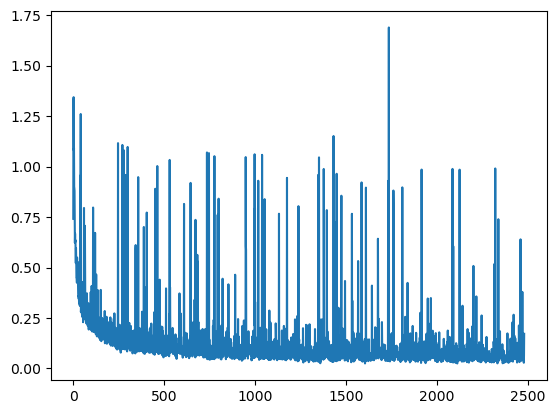

In [23]:
plt.plot(np.array(logistic_regression_loss_history), linestyle="solid")

## Training the binary classifier CNN model

In [24]:
binary_classifier_cnn_model = BinaryClassifierCNN(32)
binary_classifier_cnn_criterion = torch.nn.BCELoss()
binary_classifier_cnn_optimizer = torch.optim.Adam(binary_classifier_cnn_model.parameters(), lr=0.001)

binary_classifier_cnn_loss_history = train_model(train_loader, 10, binary_classifier_cnn_model, binary_classifier_cnn_criterion, binary_classifier_cnn_optimizer)

Epoch [1/10], Steps 248, Loss: 0.1249
Epoch [2/10], Steps 248, Loss: 0.0630
Epoch [3/10], Steps 248, Loss: 0.0481
Epoch [4/10], Steps 248, Loss: 0.0255
Epoch [5/10], Steps 248, Loss: 0.0510
Epoch [6/10], Steps 248, Loss: 0.0199
Epoch [7/10], Steps 248, Loss: 0.0162
Epoch [8/10], Steps 248, Loss: 0.0273
Epoch [9/10], Steps 248, Loss: 0.0178
Epoch [10/10], Steps 248, Loss: 0.0166


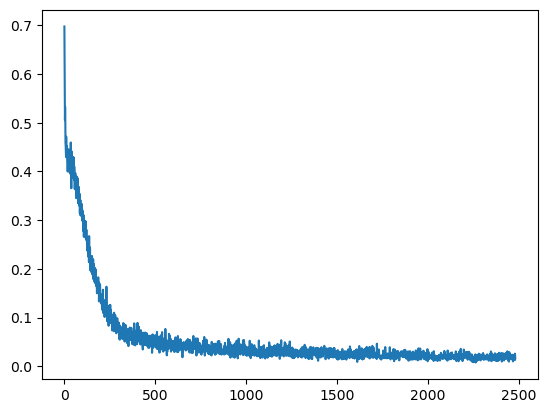

In [25]:
plt.plot(np.array(binary_classifier_cnn_loss_history), linestyle="solid")

## Training the convolutional autoencoder model

In [48]:
autoencoder_model = ConvolutionalAutoencoder()
autoencoder_criterion = torch.nn.BCELoss()
autoencoder_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.01)

autoencoder_loss_history = train_model(train_loader, 100, autoencoder_model, autoencoder_criterion, autoencoder_optimizer)

Epoch [1/100], Steps 248, Loss: 0.3622
Epoch [2/100], Steps 248, Loss: 0.3151
Epoch [3/100], Steps 248, Loss: 0.3144
Epoch [4/100], Steps 248, Loss: 0.3415
Epoch [5/100], Steps 248, Loss: 0.2736
Epoch [6/100], Steps 248, Loss: 0.2756
Epoch [7/100], Steps 248, Loss: 0.3320
Epoch [8/100], Steps 248, Loss: 0.2632
Epoch [9/100], Steps 248, Loss: 0.2989
Epoch [10/100], Steps 248, Loss: 0.3015
Epoch [11/100], Steps 248, Loss: 0.2805
Epoch [12/100], Steps 248, Loss: 0.2710
Epoch [13/100], Steps 248, Loss: 0.2499
Epoch [14/100], Steps 248, Loss: 0.3149
Epoch [15/100], Steps 248, Loss: 0.2488
Epoch [16/100], Steps 248, Loss: 0.2853
Epoch [17/100], Steps 248, Loss: 0.2852
Epoch [18/100], Steps 248, Loss: 0.2601
Epoch [19/100], Steps 248, Loss: 0.2982
Epoch [20/100], Steps 248, Loss: 0.2561
Epoch [21/100], Steps 248, Loss: 0.2559
Epoch [22/100], Steps 248, Loss: 0.2754
Epoch [23/100], Steps 248, Loss: 0.2401
Epoch [24/100], Steps 248, Loss: 0.2657
Epoch [25/100], Steps 248, Loss: 0.2767
Epoch [26

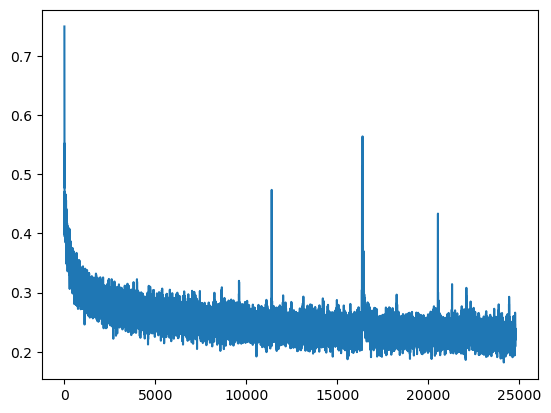

In [49]:
plt.plot(np.array(autoencoder_loss_history), linestyle="solid")

# Testing

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def test_model(test_loader, model):   
    total = 0
    correct = 0
    incorrect = 0
    
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        
        for i, batch in enumerate(test_loader):
            batch_inputs = batch['inputs']
            #batch_inputs = batch_inputs.reshape((batch_inputs.size(0), -1))
            batch_labels = batch['labels']
            batch_labels = batch_labels.reshape((batch_labels.size(0), -1))
            
            out = model(batch_inputs)
            
            targets = torch.flatten(batch_labels).type(torch.FloatTensor).numpy()
            out = torch.flatten(out).numpy()
            
            fire_predictions = np.rint(out)
            
            y_pred.extend(fire_predictions)
            y_true.extend(targets)
            
            correct += np.sum(fire_predictions == targets)
            incorrect += np.sum(fire_predictions != targets)
            
            total += len(targets)
    
    accuracy = 100 * correct/total
    print(f"Total = {total}")
    print(f"This should match the total: {correct + incorrect}")
    print(f"Total correct = {correct}")
    print(f"Total incorrect = {incorrect}")
    print(f"Overall accuracy: {accuracy}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("\nPrecision, Recall, Fscore, Support:")
    print(np.vstack(precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])))

## Testing the logistic regression model

In [30]:
test_model(test_loader, logistic_regression_model)

Total = 1396736
This should match the total: 1396736
Total correct = 1263321
Total incorrect = 133415
Overall accuracy: 90.448087541239

Confusion Matrix:
[[1258081   97777]
 [  35638    5240]]

Precision, Recall, Fscore, Support:
[[9.72453060e-01 5.08653911e-02]
 [9.27885516e-01 1.28186310e-01]
 [9.49646679e-01 7.28308836e-02]
 [1.35585800e+06 4.08780000e+04]]


## Testing the binary classifier CNN model

In [31]:
test_model(test_loader, binary_classifier_cnn_model)

Total = 1396736
This should match the total: 1396736
Total correct = 1342305
Total incorrect = 54431
Overall accuracy: 96.1029858183651

Confusion Matrix:
[[1336737   19121]
 [  35310    5568]]

Precision, Recall, Fscore, Support:
[[9.74264730e-01 2.25525538e-01]
 [9.85897491e-01 1.36210186e-01]
 [9.80046593e-01 1.69841536e-01]
 [1.35585800e+06 4.08780000e+04]]


## Testing the convolutional autoencoder model

In [50]:
test_model(test_loader, autoencoder_model)

Total = 1396736
This should match the total: 1396736
Total correct = 1322834
Total incorrect = 73902
Overall accuracy: 94.70895000916423

Confusion Matrix:
[[1316960   38898]
 [  35004    5874]]

Precision, Recall, Fscore, Support:
[[9.74108778e-01 1.31198070e-01]
 [9.71311155e-01 1.43695876e-01]
 [9.72707955e-01 1.37162872e-01]
 [1.35585800e+06 4.08780000e+04]]


# Plotting

In [35]:
TITLES = [
    'Elevation',
    'Wind\ndirection',
    'Wind\nvelocity',
    'Min\ntemp',
    'Max\ntemp',
    'Humidity',
    'Precip',
    'Drought',
    'Vegetation',
    'Population\ndensity',
    'Energy\nrelease\ncomponent',
    'Previous\nfire\nmask',
    'Fire\nmask',
    'Predicted\nfire\nmask'
]

def plot_5_predictions(loader, model, offset):
    with torch.no_grad():
        batch = next(iter(loader))
        out = model(batch['inputs'])
        out = out.reshape(out.size(0), 32, 32).numpy()
        fire_predictions = np.rint(out)
        
        print(fire_predictions.shape)
    
        n_rows = 5
        n_features = batch['inputs'].shape[1]
    
        CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
        BOUNDS = [-1, -0.1, 0.1, 1]
        NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
        fig = plt.figure(figsize=(15,6.5))
    
    for i in range(n_rows):
        for j in range(n_features + 2):
            plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(batch['inputs'][i+offset, j, :, :], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(batch['inputs'][i+offset, -1, :, :], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(batch['labels'][i+offset, 0, :, :], cmap=CMAP, norm=NORM)
            if j > n_features:
                plt.imshow(fire_predictions[i+offset], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()
    

## Plotting for the logistic regression model

(100, 32, 32)


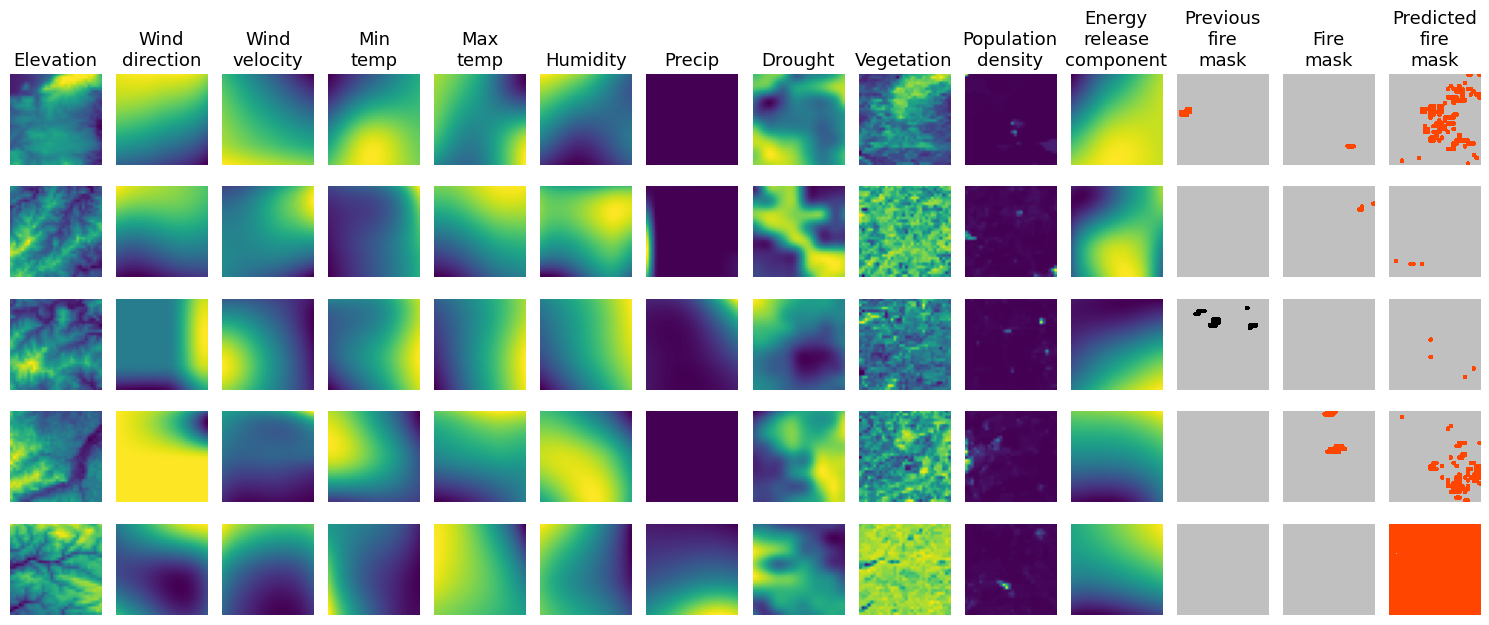

In [40]:
plot_5_predictions(test_loader, logistic_regression_model, offset=20)

## Plotting for the binary classifier CNN model

(100, 32, 32)


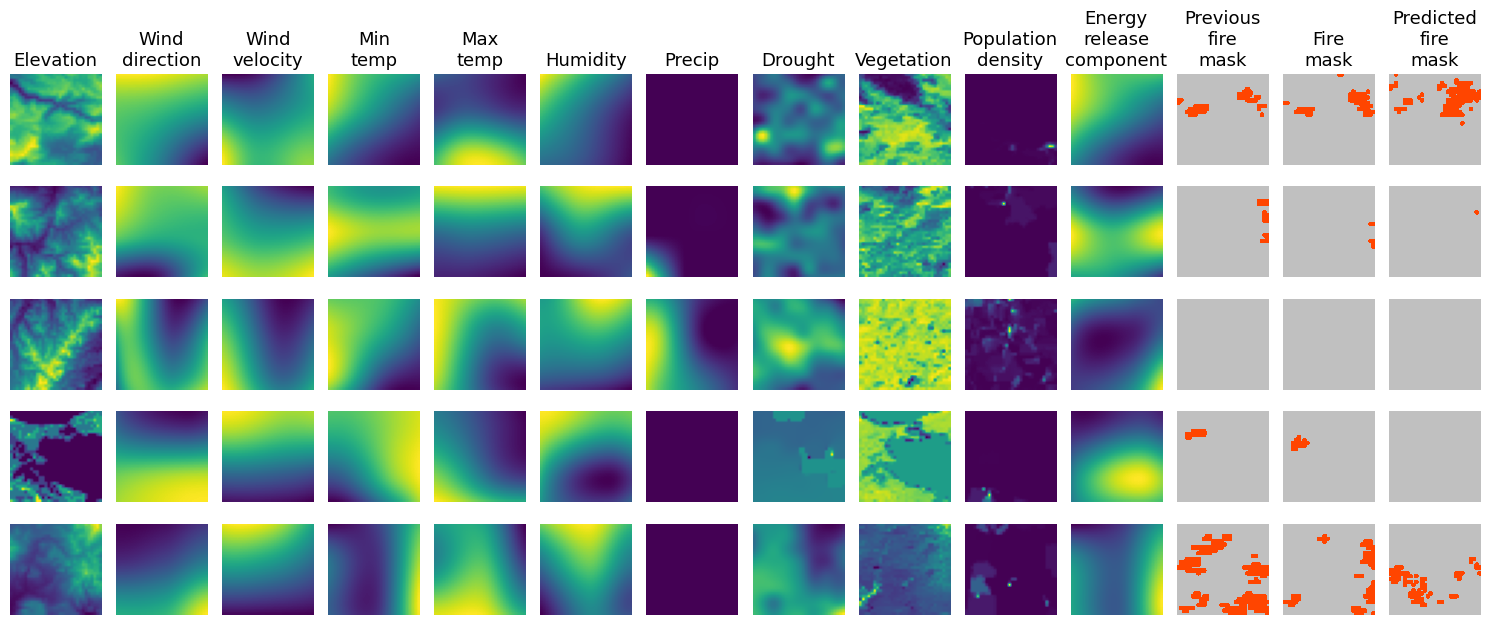

In [42]:
plot_5_predictions(test_loader, binary_classifier_cnn_model, offset=25)

## Plotting for the convolutional autoencoder model

(100, 32, 32)


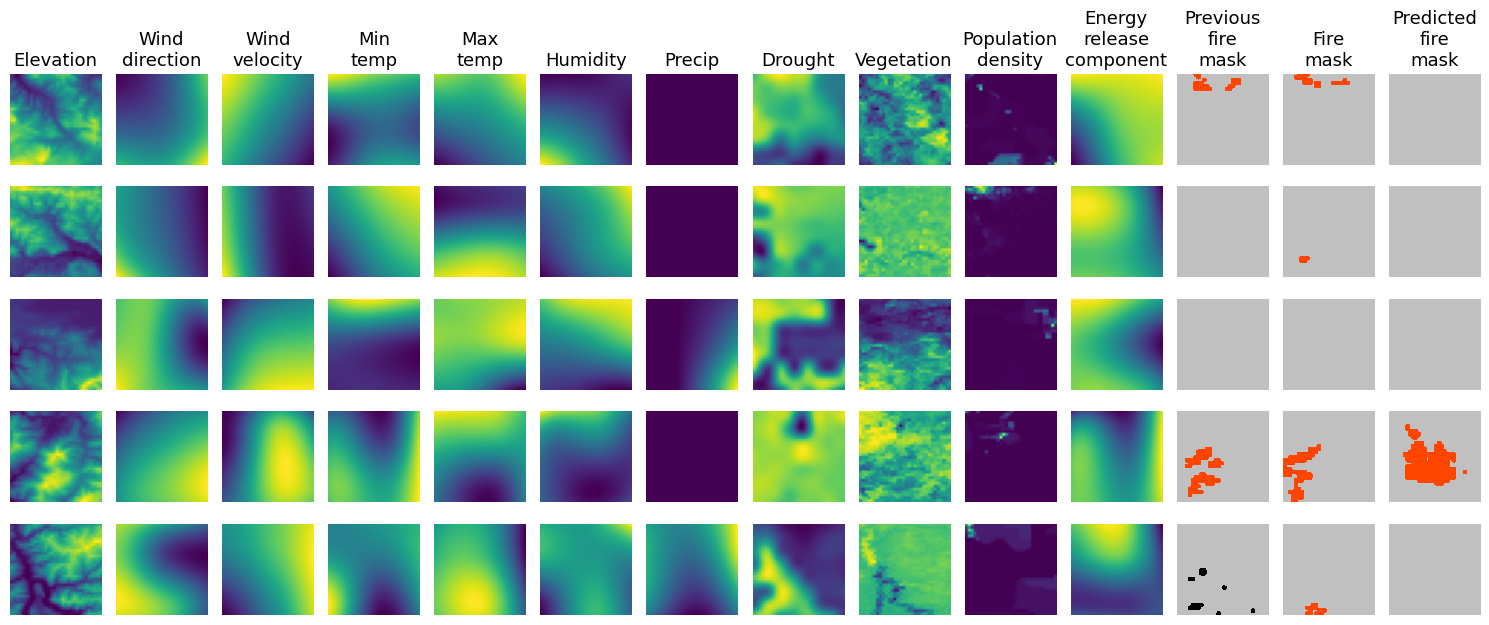

In [54]:
plot_5_predictions(test_loader, autoencoder_model, offset=55)